### **Text Analysis of Patient Feedback in HIV Services Using NLP Techniques**

##### Introduction
This project focuses on analyzing patient feedback regarding HIV service facilities. By applying natural language processing (NLP) techniques, we aim to uncover key themes in feedback that can inform improvements in service delivery and patient satisfaction.

##### Research Problem
Understanding the nuances of patient satisfaction and dissatisfaction is crucial for enhancing the quality of healthcare services. This study investigates the specific aspects of service that impact patient experiences at HIV service facilities.

##### Research Objectives
- To identify predominant themes in positive feedback from patients.
- To explore recurring issues highlighted in patient suggestions for service improvement.

##### Methodology
This analysis utilizes topic modeling and Naive Bayes classification to extract and categorize themes from unstructured patient feedback:
- **Topic Modeling:** Helps in discovering the hidden thematic structure in large collections of text. It is used here to categorize text in patient feedback into topics, each representing a specific aspect of the service.
- **Naive Bayes Classification:** Applied to classify feedback into categories such as positive, negative, and suggestions for improvement based on the presence of specific keywords.

##### Justification
Efficiently analyzing feedback allows healthcare providers to prioritize improvements and reinforce service strengths. This approach ensures that patient voices directly contribute to service enhancements.

##### Assumptions
- All feedback is assumed to be honest and accurately reflects the patients’ experiences.
- The analysis is limited to feedback provided in English.

#### Scope
The scope of this analysis encompasses the application of NLP techniques to understand patient feedback themes and classify them in a way that highlights areas for potential improvement and current strengths in HIV service delivery.

#### **Import Dependencies and Dataset**

This section imports necessary Python libraries and loads the dataset used for the analysis.

In [28]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from gensim.models import LdaModel, CoherenceModel
import numpy as np
import plotly.io as pio
pio.renderers.default = 'notebook'

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [29]:
# Load data
data = pd.read_csv("data/clm_open_ended.csv")
data.head()

,Date of feedback collection,County,Positive feedback on services,Negative feedback on services,Suggestions for improving access to services,Positive aspects of facility to emulate,General suggestions for improvement,Top 1-3 Positive aspects of care and treatment,Top 1-3 Negative aspects of care and treatment
0,2024-04-17 20:55:46,Narok,Good,NaN,To used hospital,Good services,Time,Awareness,NaN
1,2024-04-17 19:49:25,Kisumu,Quick service delivery,NaN,Additional of medics to speed service delivery,Medics talk well to clients,NaN,Quick service delivery,NaN
2,2024-04-17 19:44:28,Kisumu,Got drugs and happy,NaN,NaN,Good treatment services,NaN,Got drugs and happy.,NaN
3,2024-04-17 19:37:41,Kisumu,Quick service delivery,NaN,NaN,Good medication services,Infrastructure development and add machines to...,Quick service delivery,NaN
4,2024-04-17 19:31:12,Kisumu,Good reception from medics,NaN,NaN,Medics are patient and have good listening ear...,Quick service delivery,Good reception from medics,NaN


##### Dataset Description
This dataset comprises of responses from patients receiving care/treatment at various healthcare centres in Kenya. It consists of over 40,000 responses.

This dataset is a subset of a survey that was conducted by PEPFAR and WOFAK between 2022-2023. The survey consists of questions to collect patient feedback on their satisfaction of HIV services. The selected columns to be used in this analysis are outlined below:

1. Date of feedback collection
1. County - the county where the facility is located
1. Positive feedback on services -> opinion of the services the patient liked
1. Negative feedback on services - opinion of the services the patient did not like
1. Suggestions for improving access to services - opinion on the services the patient would like to be improved
1. Positive aspects of facility to emulate - opinion of the services the patient liked that can be emulated by other facilities
1. General suggestions for improvement - opinion on what the patient would like to be improved
1. Top 1-3 Positive aspects of care and treatment - opinion of what the patient liked in terms of care and treatment
1. Top 1-3 Negative aspects of care and treatment - opinion of what the patient did not like in terms of care and treatment

#### **Data Cleaning and Preprocessing**

Focuses on preparing the raw data for analysis by cleaning and preprocessing. This includes removing irrelevant or duplicate data, handling missing values, and any transformations needed to convert the data into a usable format. The goal is to ensure data quality and reliability for accurate analysis.

In [3]:
print("Data shape before cleaning: ", data.shape)

Data shape:  (60749, 9)


In [4]:
# Drop columns
data.drop(['Date of feedback collection', 'County'], axis=1, inplace=True)

In [5]:
# Drop duplicates
data = data.drop_duplicates()

In [6]:
print("Data shape after first cleaning: ", data.shape)

Data shape:  (49072, 7)


In [7]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Positive feedback on services                       375
Negative feedback on services                      7748
Suggestions for improving access to services       5207
Positive aspects of facility to emulate            1404
General suggestions for improvement                6383
Top 1-3 Positive aspects of care and treatment     2575
Top 1-3 Negative aspects of care and treatment    30856
dtype: int64


In [8]:
# Fill missing values with empty string
data.fillna('', inplace=True)

In [9]:
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Positive feedback on services                     0
Negative feedback on services                     0
Suggestions for improving access to services      0
Positive aspects of facility to emulate           0
General suggestions for improvement               0
Top 1-3 Positive aspects of care and treatment    0
Top 1-3 Negative aspects of care and treatment    0
dtype: int64


In [11]:
# Combine feedback columns
data['positive_feedback'] = data[['Positive feedback on services', 'Top 1-3 Positive aspects of care and treatment']].agg('. '.join, axis=1)
data['negative_feedback'] = data[['Negative feedback on services', 'Top 1-3 Negative aspects of care and treatment']].agg('. '.join, axis=1)

# Drop columns. This notebook will focus on positive feedback and negative feedback columns
data.drop(['Positive feedback on services', 'Negative feedback on services', 'Suggestions for improving access to services', 'Positive aspects of facility to emulate', 'General suggestions for improvement', 'Top 1-3 Positive aspects of care and treatment', 'Top 1-3 Negative aspects of care and treatment'], axis=1, inplace=True)

In [12]:
# Data preprocessing using tokenization, normalizaiton, removal of stopwords, and lemmatization
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    other_stop = ['service', 'nan', 'nothing', 'comment', 'comments', 'none', 'non', 'plumpy', 'nut', 'ok', 'okay']
    extended_stop_words = stop_words.union(other_stop)
    tokens = [token for token in tokens if token not in extended_stop_words and token.isalpha()]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

text_columns = ['positive_feedback', 'negative_feedback']
for column in text_columns:
    data[column] = data[column].astype(str).apply(preprocess_text)

#### **Exploratory Data Analysis**

Provides a comprehensive examination of the dataset to uncover initial insights and understand the underlying patterns and trends. This analysis helps to form hypotheses and guide further detailed analysis.

##### WordCloud Generation

Generates a visual word cloud from the dataset to highlight the most frequent and significant words within the text. This visualization aids in quickly perceiving key themes and concepts prevalent in the dataset.

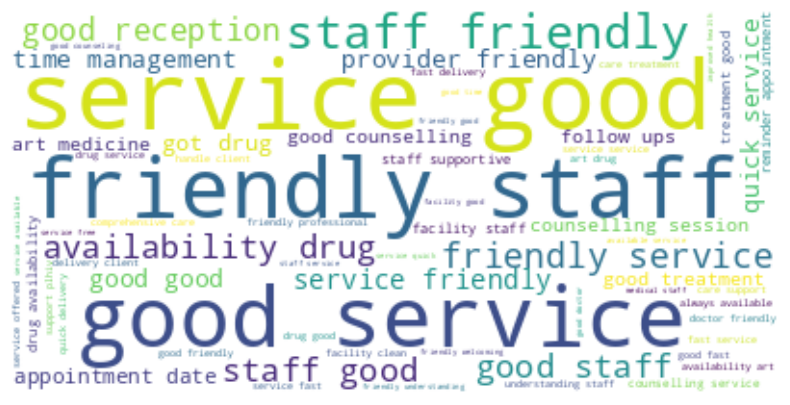

In [13]:
# Generate a word cloud for the 'positive_feedback' column
text = ' '.join(data['positive_feedback'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

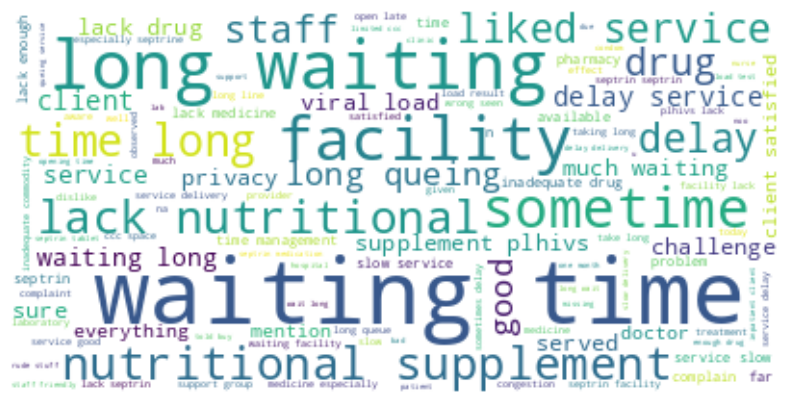

In [14]:
# Generate a word cloud for the 'negative_feedback' column
text = ' '.join(data['negative_feedback'].dropna())
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Topic Modelling Using LDA

Applies topic modeling techniques to discover abstract topics from the collection of texts. This section outlines the method and parameters used for modeling and visualizes the topics to interpret the thematic structure of the data.

In [15]:
tokenized_docs = [word_tokenize(doc.lower()) for doc in data['positive_feedback'] if isinstance(doc, str)]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

coherence_values = []
topic_numbers = range(2, 15)  # Topic range

for num_topics in topic_numbers:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto', eta='auto')
    coherencemodel = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Select the model that gives the highest coherence score
optimal_index = np.argmax(coherence_values)
optimal_topics = topic_numbers[optimal_index]
print("Optimal number of topics for positive_feedback:", optimal_topics)

# Plotting the coherence scores using Plotly
fig = go.Figure(data=go.Scatter(x=list(topic_numbers), y=coherence_values, mode='lines+markers'))
fig.update_layout(title='LDA Model Coherence Scores by Number of Topics for positive_feedback',
                  xaxis_title='Number of Topics',
                  yaxis_title='Coherence Score',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.show()

Optimal number of topics for positive_feedback: 12


In [16]:
tokenized_docs = [word_tokenize(doc.lower()) for doc in data['negative_feedback'] if isinstance(doc, str)]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

coherence_values = []
topic_numbers = range(2, 15)  # Topic range

for num_topics in topic_numbers:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto', eta='auto')
    coherencemodel = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Select the model that gives the highest coherence score
optimal_index = np.argmax(coherence_values)
optimal_topics = topic_numbers[optimal_index]
print("Optimal number of topics for negative_feedback:", optimal_topics)

# Plotting the coherence scores using Plotly
fig = go.Figure(data=go.Scatter(x=list(topic_numbers), y=coherence_values, mode='lines+markers'))
fig.update_layout(title='LDA Model Coherence Scores by Number of Topics for negative_feedback',
                  xaxis_title='Number of Topics',
                  yaxis_title='Coherence Score',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.show()

Optimal number of topics for negative_feedback: 11


##### *Topic Modelling of Positive Feedback*

In [17]:
tokenized_docs = [word_tokenize(doc) for doc in data['positive_feedback']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 8
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook(local=True)
display(HTML(pyLDAvis.display(vis).data.replace('width: 900px;', 'width: 700px;').replace('height: 900px;', 'height: 700px;')))

Topic 1 - `staff`, `friendly`

Topic 2 - `good`, `treatment`

Topic 3 - `drug`, `free`, `availability`, `medicine`

Topic 5 - `confidentiality`

Topic 6 - `counselling`, `support`

Topic 7 - `provider`, `available`

##### *Topic Modelling of Negative Feedback*

In [18]:
tokenized_docs = [word_tokenize(doc) for doc in data['negative_feedback']]
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

num_topics = 4
passes = 15
iterations = 400

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook(local=True)
display(HTML(pyLDAvis.display(vis).data.replace('width: 900px;', 'width: 700px;').replace('height: 900px;', 'height: 700px;')))

Topic 1 - `time`, `waiting`, `long`

Topic 2 - `staff`, `harassment`, `rude`, `nutritional`, `supplement`, `delay`

Topic 3 - `drug`, `medicine`, `lack`

#### **Predictive Analysis**

Implements a Naive Bayes classifier to categorize text data into predefined classes based on learned features from the training dataset. This section details the model training, application, and the metrics used to evaluate its performance.

In [19]:
feedback_types = {
    'positive_feedback': {
        'FriendlyStaff': 'friendly',
        'GoodTreatment': 'treatment',
        'Confidentiality': 'confidentiality',
    },
    'negative_feedback': {
        'Harassment': 'harassment',
        'Delays': 'delay',
        'LackDrugs': 'drug'
    }
}

# Create binary flags for each phrase in each feedback type
for feedback_column, phrases in feedback_types.items():
    for col, phrase in phrases.items():
        data[col] = data[feedback_column].str.lower().apply(lambda x: 1 if phrase in x else 0)

In [20]:
def train_and_evaluate(data, feature_col, label_col):
    # Vectorize the feedback
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(data[feature_col])
    y = data[label_col]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    return df_report.reset_index().rename(columns={'index': 'Metric'})

# Initialize an empty DataFrame to store all reports
all_reports = pd.DataFrame()

# Iterate over each feedback type and phrase
for feedback_column, phrases in feedback_types.items():
    for col in phrases:
        report_df = train_and_evaluate(data, feedback_column, col)
        report_df['Feature'] = col  # Add feature name to each row
        all_reports = pd.concat([all_reports, report_df], axis=0)

# Reshape the DataFrame to make features as columns
final_report = all_reports.pivot(index='Metric', columns='Feature', values=['f1-score'])
final_report

f1-score                                                   \
Feature      Confidentiality    Delays FriendlyStaff GoodTreatment Harassment   
Metric                                                                          
0                   0.993121  0.997145      0.964064      0.992756   0.999643   
1                   0.891174  0.850136      0.913721      0.881625   0.787879   
accuracy            0.987061  0.994396      0.949261      0.986347   0.999287   
macro avg           0.942148  0.923641      0.938893      0.937191   0.893761   
weighted avg        0.986598  0.993984      0.949046      0.985679   0.999211   

                        
Feature      LackDrugs  
Metric                  
0             0.996919  
1             0.877847  
accuracy      0.993989  
macro avg     0.937383  
weighted avg  0.993655

In [21]:
def plot_feedback_type_bars(feedback_type, colors):
    # Initialize the figure
    fig = go.Figure()

    # Loop through each feature in the specified feedback type
    for feature, color in colors.items():
        # Check if the feature exists in the DataFrame
        if (feedback_type, feature) in final_report.columns:
            feature_data = final_report[(feedback_type, feature)]
            fig.add_trace(go.Bar(
                x=feature_data.index,  # Metrics like 0, 1, accuracy, macro avg, etc.
                y=feature_data.values,
                name=feature,
                marker_color=color
            ))

    # Update the layout
    fig.update_layout(
        title=f'{feedback_type.capitalize()} Feedback - F1-Score Analysis',
        xaxis_title='Metrics',
        yaxis_title='F1-Score',
        xaxis={'categoryorder':'total descending'},
        barmode='group',
        legend_title_text='Features'
    )
    fig.show()

# Define the features and their associated colors for positive and negative feedback
positive_features = {
    'FriendlyStaff': 'green',
    'GoodTreatment': 'lightgreen',
    'Confidentiality': 'olive'
}

negative_features = {
    'RudeNurse': 'red',
    'LongWait': 'darkred',
    'Harassment': 'firebrick'
}

In [22]:
# Plot all positive features
plot_feedback_type_bars('positive_feedback', positive_features)

In [23]:
# Plot all negative features
plot_feedback_type_bars('negative_feedback', negative_features)

#### **Interpretation of Results**

Analyzes and discusses the outcomes from both the topic modeling and classification tasks. This section interprets how the results address the research questions, providing insights into the data's implications on HIV service evaluations.

#### **Conclusion**

Summarizes the key findings and the overall insights gained from the analysis. It also reflects on the methodology's effectiveness and suggests potential areas for future research or improvement in the analysis process.